# MATH70105 Milestone 2

## Sebastian Graban

The purpose of this analysis is to delve into existing networks, develop an early statistical framework for evaluating the similarity between two sets of networks, and re-produce the model developed in the GraphGen paper (1). First of all we explore the Enzymes dataset as developed by Schomburg et a.l. (2), which is comprised of 600 graphs representing enzymes, with labelled nodes and no labelled edges. This set of graphs forms the basis of this analysis; however, for further work additional datasets will need to be utilised as is shown in both the GraphGen paper (1) and GraphRNN (3) studies. This dataset will then be used to re-produce the LSTM based autoregressive edge sequence generation model for generating synthetic graphs. We will implement a statistical framework that will analyse many graph aspects to compare the original networks to the synthetically generated ones. The statistics that we will use can be found in Guo (2022) (4). The model reproduction is aimed to take the original code from the authors paper and augment it to become more modular such that we can explore new model methodologies such as utilising a transformer or reformer architecture to model the autoregressive properties of the graphs. This work will provide the foundations for this further analysis by both providing a statistical framework to analyse synthetic graphs against their original datasets along with a code structure that should more easily allow for more methodologies to be explored. 

As a result of issues with the zip location the additional files and dataset can be found at: https://github.com/SebGraban/graphreformer.git 

In [ ]:
# Load libraries

import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from graphreformer.datasests.ENZYMES.load_data import get_enzymes_data
import networkx as nx
import matplotlib.pyplot as plt
from graphgen.dfscode.dfs_wrapper import get_min_dfscode
from graphreformer.model.data import create_tf_dataset
from graphreformer.model.graphregressive import GraphAR

# Graph Generation

We load the enzyme networks from the dataset using the networkx python library. The code to generate the networks has been mostly taken from the GraphGen code, which can be found in the zip file attached. It has however been altered somewhat. 

19474
37282


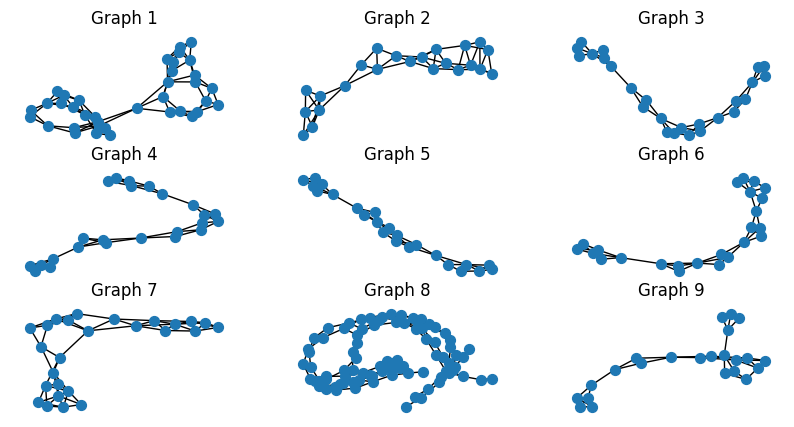

In [29]:
# Get networkx graphs and node list from the ENZYMES dataset
enzyme_graphs, enzympe_node_list = get_enzymes_data()

# Create a plot to visualize the first 9 graphs in the dataset
plt.figure(figsize=(10, 5))
for graph_idx in range(9):
    plt.subplot(3, 3, graph_idx + 1)
    plt.title(f'Graph {graph_idx + 1}')
    nx.draw(enzyme_graphs[graph_idx], with_labels=False, node_size=50, font_size=8)
plt.show()

# Statistical Evaluation Framework

We now develop a statisitcal framework to analyse if two sets of graphs are similar. As per Guo we use 2 distribution measures, the degree node distribution and the clustering coefficient distributions. For each set of graphs we generate a degree node and clustering coefficient distribution for each graph and then we comapre these two distributions using MMD (Maximum Mean Discrepancy) as introduced by Gretton et a.l (5). The closer the resulting MMD is to 0 the more likely it is that the two sets of graphs follow the same degree or clustering coefficient distributions. This will allow us to easily develop benchmarks which we can use to analyse any future modifications or alterations in methodology. For now we have excluded orbit distribution as a measure; however, this will be added to remain consistent with the original GraphGen paper.  

In addition to the distributionn measures we use the 4 scaler measures suggested by Gao, the largest connected component, triangle count, characteristic path length, and assortativity. For each set of of graphs we generate a distribution of these scaler values and then compare the two distributions using the Jenson Shannon distance measure. The close the value is to 0 the closer the two distributions are to being the same. 

Generate the plots for two random samples from the same dataset to provide a baseline for graphs from the same set

MMD for degree distribution: 0.01534151245996689
MMD for clustering coefficient distribution: 0.013676778014307778
Jensen-Shannon divergence for largest component size: 0.1870532709215875
Jensen-Shannon divergence for triangle count: 0.2305791569734801
Jensen-Shannon divergence for characteristic path length: 0.23066303936386842


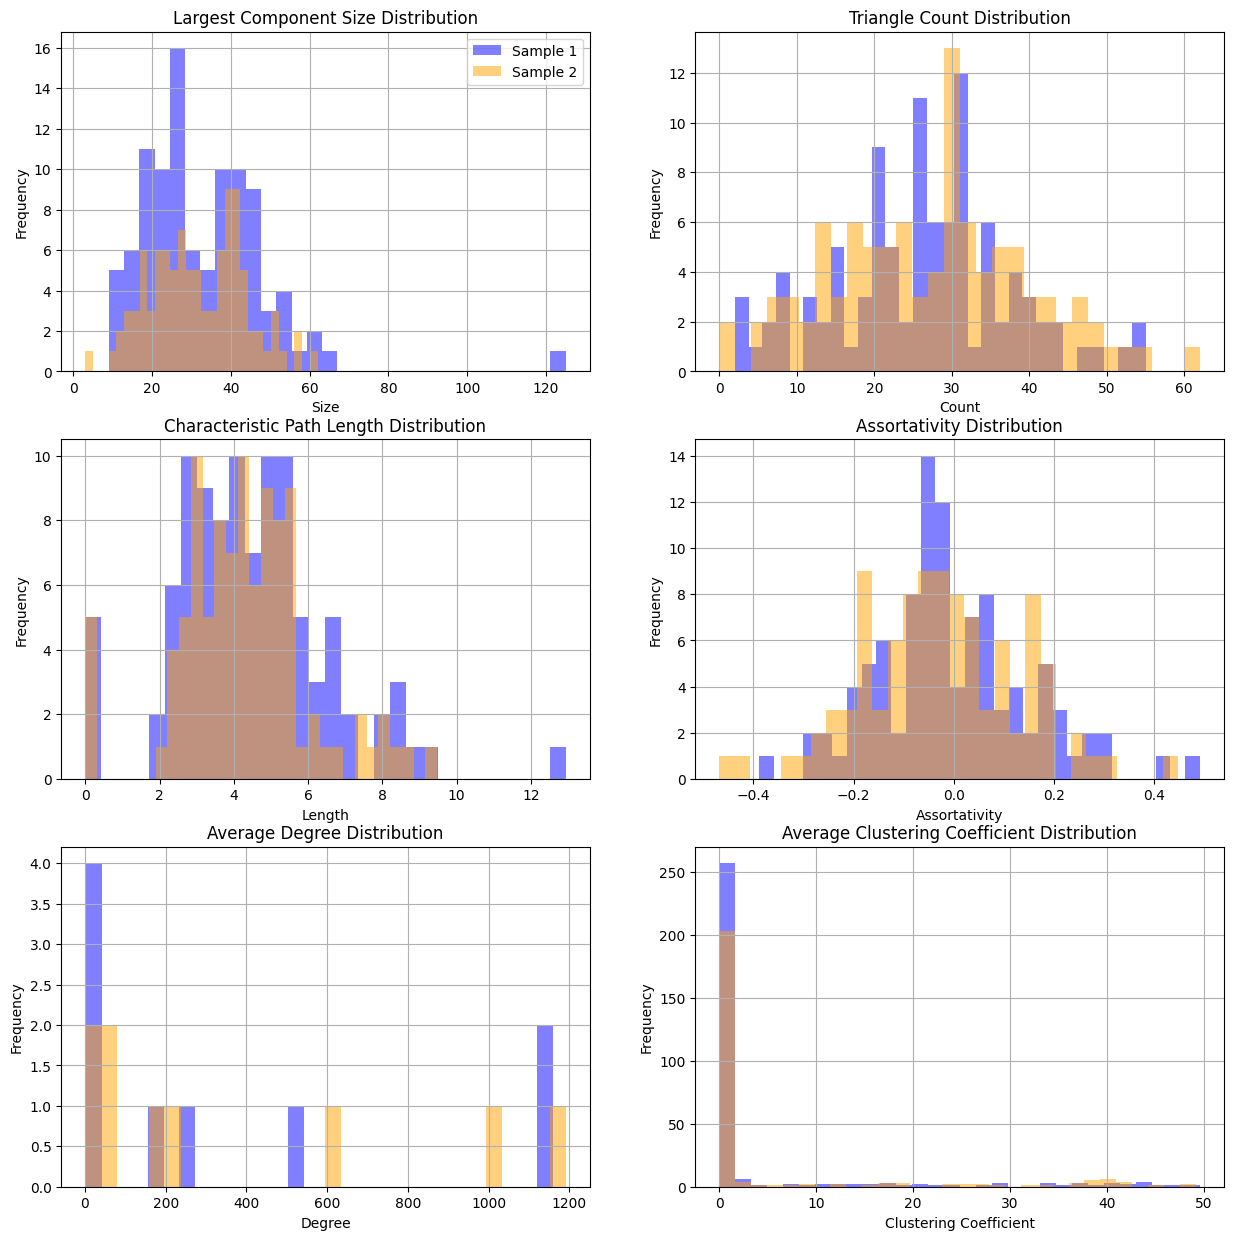

In [32]:
from random import sample
from graphreformer.stats import generate_sample_plots

generate_sample_plots(
    graph_samples_1 = sample(enzyme_graphs, 100),
    graph_samples_2 = sample(enzyme_graphs, 100),
)

# Minimum DFS code generation

The networks that are loaded need to be encoded in a way that can be passed into a model. As per the GraphGen paper we use minimum DFS codes to encode the graph into a sequence of edges that correspond to the lexical minimum depth first search traversal of the graph. This code has been copied from the GraphGen repository as it is very efficient and there are no alterations requried to it. 

In [ ]:
dfscodes = []
# Generate DFSCodes for all the graphs in the dataset
for i in range(600):
    try:
        dfscode = get_min_dfscode(enzyme_graphs[i])
        dfscodes.append(dfscode)
    except Exception as e:
        continue

XTLE: PRINTING NORMAL DFS ANSWER |V| = 62  |E| = 108
XTLE: PRINTING NORMAL DFS ANSWER |V| = 44  |E| = 78


In [ ]:
# Convert the list of DFSCodes to a TensorFlow dataset with an end
# of sequence token and one hot encoding for the features
dataset, features = create_tf_dataset(
    dfscodes,
    batch_size=32
)

# The output shape is (batch_size, max_sequence_length, num_features)
for input_seq, target_seq, len_seq in dataset:
    print("\nBatch:")
    print(f"Input shape: {input_seq.shape}")
    print(f"Target shape: {target_seq.shape}")
    break

2025-06-15 18:52:24.432622: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected



Batch:
Input shape: (32, 150, 304)
Target shape: (32, 150, 304)


# Model Generation

This section of the code focuses on creating the model proposed in the GraphGen paper, which utilises a stacked LSTM layer that takes the encoded DFS codes and attempts to model long-term dependencies in the graph. The output from the stacked LSTM cells is then fed through 5 simple MLP layers, which produce the 5 outputs that make up the DFS code.

(node_1, node_2, node_lable_1, edge_label, node_label_2)

These represent categorical variables that correspond to the one-hot encoding that we produced earlier. In the original repository, this was all done in functions; here we have refactored the code to produce a class which takes in an autoregressive element and then the 5 MLP models. This will allow us in the future to swap out the autoregressive stacked LSTM model with a different architecture with ease, allowing further research to be conducted. This additional flexibility is the main addition in this analysis. The results of the model are not likely to be as strong as the original paper due to the lack of time to develop a model. Furthermore, there could be small errors or inefficiencies in the code; however, the main functionality has been tested to work correctly. 

Furthermore, the original repository produced the results using PyTorch, here we have used Tensorflow which has required a more delicate managing of the hidden state of the LSTM cells to reproduce the results seen in the original paper.

In [ ]:
# Create Models 
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from graphreformer.model.graphregressive import StackedLSTM

# Define a simple MLP model for the 5 output dimensions
def mlp_model(output_dim):
    inputs_mlp = Input(shape=(None,256))
    h_mlp = Dense(512, activation='relu')(inputs_mlp)
    h_mlp = Dropout(0.2)(h_mlp)
    h_mlp = Dense(output_dim,activation='softmax')(h_mlp)
    model = Model(inputs=inputs_mlp, outputs=h_mlp)
    return model

# Create stacked LSTM model for autoregressive prediction
ar_model = StackedLSTM(
    lstm_units=256,
    num_layers=4,
)

# Create the GraphGen model using the autoregressive model and MLPs for each output
graph_ar = GraphAR(
    ar_model,
    mlp_model(
        features['max_num_nodes']+1
    ),
    mlp_model(
        features['max_num_nodes']+1
    ),
    mlp_model(
        len(features['node_vocab'])+1,
    ),
    mlp_model(
        len(features['edge_vocab'])+1,
    ),
    mlp_model(
        len(features['node_vocab'])+1,
    ),
    features=features,
)

In [ ]:
graph_ar.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

graph_ar.fit(
    dataset,
    epochs=100,
)

In [18]:
# Generate a set of new graphs to compare with the original dataset

predicted_graphs = []

for _ in range(100):
    g = graph_ar.predict_graph()
    if g.number_of_nodes() > 4:
        predicted_graphs.append(g)

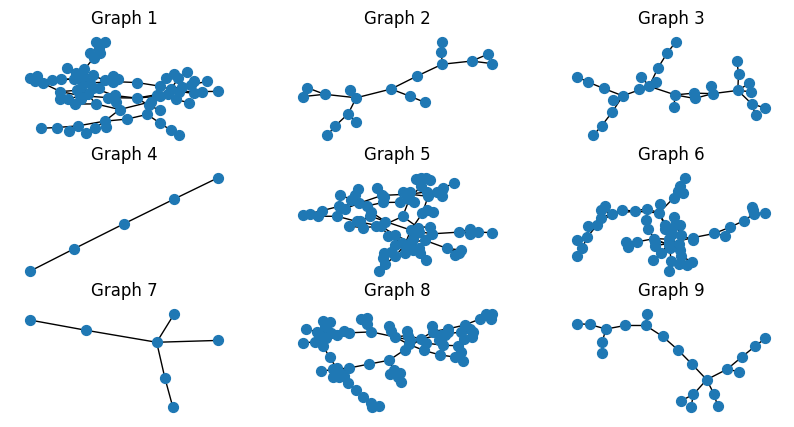

In [30]:
# Create a plot to visualize the first 9 predicted graphs
plt.figure(figsize=(10, 5))
for graph_idx in range(9):
    plt.subplot(3, 3, graph_idx + 1)
    plt.title(f'Graph {graph_idx + 1}')
    nx.draw(predicted_graphs[graph_idx], with_labels=False, node_size=50, font_size=8)
plt.show()

MMD for degree distribution: 0.05657210749063103
MMD for clustering coefficient distribution: 0.8048093440887361
Jensen-Shannon divergence for largest component size: 0.36503025016986507
Jensen-Shannon divergence for triangle count: 0.6272022483827208
Jensen-Shannon divergence for characteristic path length: 0.23811329085034313


/root/thesus/venv/lib/python3.12/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


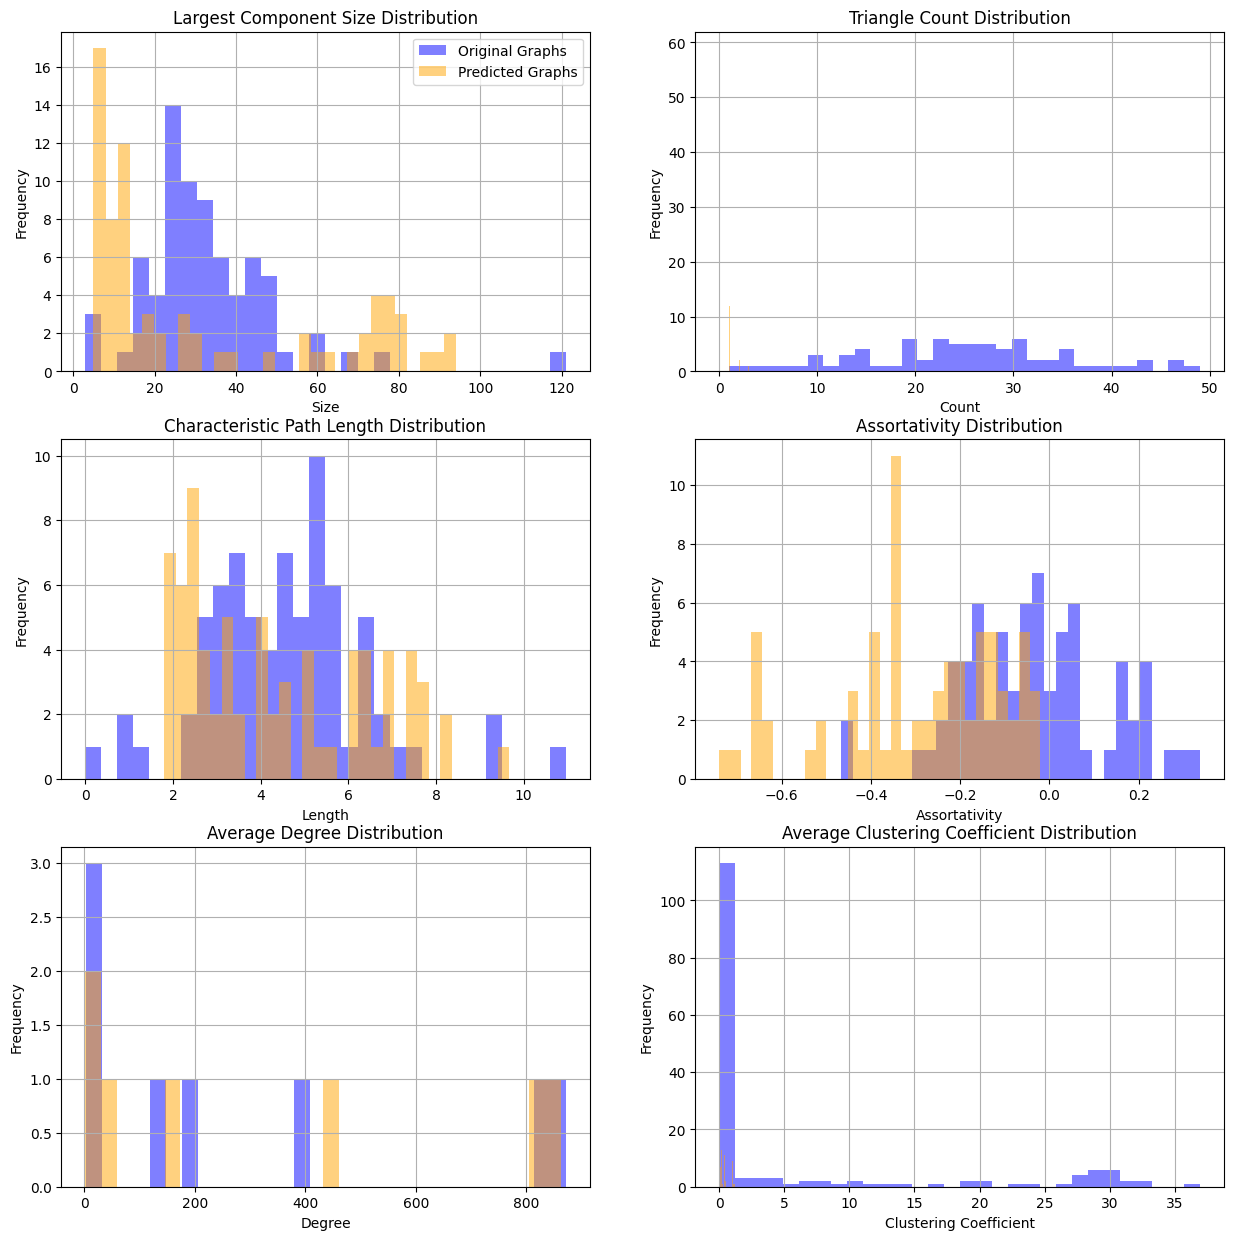

In [33]:
from random import sample

graph_samples_1 = sample(enzyme_graphs, len(predicted_graphs))

generate_sample_plots(
    graph_samples_1 = graph_samples_1,
    graph_samples_2 = predicted_graphs,
    label_1='Original Graphs',
    label_2='Predicted Graphs',
)

# Conclusions

First of all we have successfully developed both a statistical method for evaluating two sets of graphs and created a modularised version of the GraphGen model. The results clearly show that the model has somewhat been able to capture the features of the original dataset; however, there is a long way to go before it can reproduce the results from the paper. First of all the paper used 4000 epochs and trained for 3 hours which is significantly more than what we have done here. Therefore, the first next step would be to more faithfully reproduce the results that were found in the paper. All this analysis forms the basis and a baseline to explore new methodologies such as utilising a transformer in place of the stacked LSTM cells. This may be able to capture more global graph properties, which should be reflected in measures such as the largest connected component. 

The analysis also needs to be extended to other datasets, in fact the Enzuymes dataset was one of the few datasets that performed better under the GraphRNN than the GraphGen model, so could be particularly susceptible to performing poorly under this methodology. By taking the data pre-processing out of the model as was the case in the GraphGen repository we can also explore new ways of processing the graph before inputting it into the model. 

For the attached zip file we have included the GraphGen repository as we use some of the code from it and also as a reference to many of the fuctions and classes we have developed. 

# References

1) Goyal, N., Jain, H.V. and Ranu, S., 2020, April. Graphgen: A scalable approach to domain-agnostic labeled graph generation. In Proceedings of The Web Conference 2020 (pp. 1253-1263).

2) Schomburg, I., Chang, A., Hofmann, O., Ebeling, C., Ehrentreich, F. and Schomburg, D., 2002. BRENDA: a resource for enzyme data and metabolic information. Trends in biochemical sciences, 27(1), pp.54-56.

3) You, J., Ying, R., Ren, X., Hamilton, W. and Leskovec, J., 2018, July. Graphrnn: Generating realistic graphs with deep auto-regressive models. In International conference on machine learning (pp. 5708-5717). PMLR.

4) Guo, X. and Zhao, L., 2022. A systematic survey on deep generative models for graph generation. IEEE Transactions on Pattern Analysis and Machine Intelligence, 45(5), pp.5370-5390.

5) Gretton, A., Borgwardt, K.M., Rasch, M.J., Schölkopf, B. and Smola, A., 2012. A kernel two-sample test. The Journal of Machine Learning Research, 13(1), pp.723-773.